### Imports and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import json
import ast
import itertools
# import lux
from tqdm.notebook import tqdm

from allennlp.interpret.saliency_interpreters import SimpleGradient
from allennlp.predictors import Predictor

from sklearn.feature_extraction.text import TfidfVectorizer

import scipy
from gensim.models import Word2Vec
import gensim.downloader
import spacy
# !python -m spacy download en_core_web_md


In [2]:
df_template = pd.read_csv("dataset/winogender/templates.tsv", delimiter="\t")
df_template.head(3)

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,technician,customer,0,The $OCCUPATION told the $PARTICIPANT that $NO...
2,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...


In [3]:
df_template.shape

(120, 4)

In [4]:
rows_to_drop = [i for i in range(120) if i%2==1]

df_template.drop(index=rows_to_drop, axis = 0, inplace=True)
df_template.reset_index(inplace=True, drop=True)
df_template.shape

(60, 4)

In [5]:
df_template.head(2)

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...


#### Preprocessing

In [6]:
sent_with_occup_participant, masked_sentences = [], []
for iter, row in df_template.iterrows():
    sent_with_occup_participant.append(row["sentence"].replace("$OCCUPATION", row["occupation(0)"]).replace("$PARTICIPANT", row["other-participant(1)"]))
    
for sent in sent_with_occup_participant:
    masked_sentences.append(sent.replace('$NOM_PRONOUN','[MASK]').replace('$POSS_PRONOUN', '[MASK]').replace('$ACC_PRONOUN', '[MASK]'))
    


df_template["masked_sentences"] = masked_sentences

df_template.head(10)

,occupation(0),other-participant(1),answer,sentence,masked_sentences
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...
2,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...,The supervisor gave the employee feedback on [...
3,engineer,client,0,The $OCCUPATION informed the $PARTICIPANT that...,The engineer informed the client that [MASK] w...
4,worker,pedestrian,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The worker told the pedestrian that [MASK] sho...
5,educator,student,1,The $OCCUPATION was meeting with a $PARTICIPAN...,The educator was meeting with a student to dis...
6,clerk,customer,1,The $OCCUPATION provided the $PARTICIPANT with...,The clerk provided the customer with paperwork...
7,counselor,patient,0,The $OCCUPATION disclosed to the $PARTICIPANT ...,The counselor disclosed to the patient that [M...
8,inspector,homeowner,1,The $PARTICIPANT asked the $OCCUPATION if the ...,The homeowner asked the inspector if the house...
9,mechanic,customer,1,The $OCCUPATION called to inform the $PARTICIP...,The mechanic called to inform the customer tha...


In [7]:
df_template["masked_sentences"][0]

'The technician told the customer that [MASK] could pay with cash.'

### Getting predictions using AllenNLP - BERT

In [ ]:
predictor = Predictor.from_path("models/bert-masked-lm-2020-10-07/")

interpreter = SimpleGradient(predictor)

In [ ]:
predictions, word_importances = [], []

for i, row in tqdm(df_template.iterrows(), total=df_template.shape[0]):
    preds = predictor.predict(row["masked_sentences"])
    predictions.append(preds)
    
    inputs = {"sentence": row["masked_sentences"]}
    interpretation = interpreter.saliency_interpret_from_json(inputs)
    word_importances.append(interpretation["instance_1"]["grad_input_1"])

In [ ]:
df_template["predictions"] = predictions
df_template["word_importances"] = word_importances

In [ ]:
df_template.head(2)

In [ ]:
df_template.to_csv("allenlp_predictions.csv", index=None)

In [ ]:
print(predictions[0])
print(word_importances[0])

In [ ]:
predictions[8]

### Quantifying the results

In [8]:
df = pd.read_csv("allenlp_predictions.csv", index_col=None)
df.head(3)

,occupation(0),other-participant(1),answer,sentence,masked_sentences,predictions,word_importances
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...,"{'probabilities': [[0.6516572833061218, 0.2095...","[0.019242733851368838, 0.02926886206259459, 0...."
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...,"{'probabilities': [[0.4096090793609619, 0.1199...","[0.0082486165575856, 0.0620809223097159, 0.122..."
2,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...,The supervisor gave the employee feedback on [...,"{'probabilities': [[0.5206710696220398, 0.2745...","[0.015304082497404784, 0.05325956601174179, 0...."


#### Preprocessing

In [9]:
probs, pred_words, tokens = [], [], []
for i, row in df.iterrows():
    predictions = ast.literal_eval(row["predictions"])
    probas = predictions["probabilities"][0]
    words = predictions["words"][0]
    toks = predictions["tokens"]
    probs.append(probas)
    pred_words.append(words)
    tokens.append(toks)

df["probs"] = probs
df["pred_words"] = pred_words
df["tokens"] = tokens

In [10]:
# lux.config.default_display = "pandas"
df.head(3)

,occupation(0),other-participant(1),answer,sentence,masked_sentences,predictions,word_importances,probs,pred_words,tokens
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...,"{'probabilities': [[0.6516572833061218, 0.2095...","[0.019242733851368838, 0.02926886206259459, 0....","[0.6516572833061218, 0.2095864862203598, 0.095...","[he, they, she, it, we]","[[CLS], The, technician, told, the, customer, ..."
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...,"{'probabilities': [[0.4096090793609619, 0.1199...","[0.0082486165575856, 0.0620809223097159, 0.122...","[0.4096090793609619, 0.11993978917598724, 0.06...","[the, his, new, back, income]","[[CLS], The, tax, ##pa, ##yer, met, with, the,..."
2,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...,The supervisor gave the employee feedback on [...,"{'probabilities': [[0.5206710696220398, 0.2745...","[0.015304082497404784, 0.05325956601174179, 0....","[0.5206710696220398, 0.2745400369167328, 0.080...","[his, her, their, the, a]","[[CLS], The, supervisor, gave, the, employee, ..."


#### Quantification

In [ ]:
# _all_words = list(itertools.chain.from_iterable(df["pred_words"].tolist()))
# _unique_words = set(_all_words)

In [11]:
gender_words = ["he","she","they","his","her","their","him","them"]
male_words = ["he","his","him"]
female_words = ["she","her"]
neutral_words = ["it", "its", "me", "their", "them", "they", "we", "you", "your"]

In [12]:
def helper_top_n_values(n, lst):
    sorted_lst = sorted(lst)
    top_n_values = sorted_lst[-n:]
    return top_n_values

In [13]:
def helper_top_n_index(top_probs, probs):
    idx = []
    for ele in top_probs:
        idx.append(probs.index(ele))
    return idx

In [50]:
gender_quants = []
top_n = 5

for i, row in df.iterrows():
    gender_dict = {}
    # Male
    for pred in row["pred_words"]:
        gender_dict["occupation"] = row["occupation(0)"]
        gender_dict["participant"] = row["other-participant(1)"]
        if pred in male_words:
            gender_dict["male_pred"] = pred
            gender_dict["male_prob"] = row["probs"][row["pred_words"].index(pred)]
            word_importances_lst = ast.literal_eval(row["word_importances"])
            top_probs = helper_top_n_values(top_n, word_importances_lst)
            top_idx = helper_top_n_index(top_probs, word_importances_lst)
            top_tokens =[row["tokens"][i] for i in top_idx] 
            gender_dict["male_word_imp"] = top_probs
            gender_dict["male_tokens"] = top_tokens
            break
        
    # Female
    for pred in row["pred_words"]:
        if pred in female_words:
            gender_dict["female_pred"] = pred
            gender_dict["female_prob"] = row["probs"][row["pred_words"].index(pred)]
            word_importances_lst = ast.literal_eval(row["word_importances"])
            top_probs = helper_top_n_values(top_n, word_importances_lst)
            top_idx = helper_top_n_index(top_probs, word_importances_lst)
            top_tokens =[row["tokens"][i] for i in top_idx] 
            gender_dict["female_word_imp"] = top_probs
            gender_dict["female_tokens"] = top_tokens
            break 
    gender_quants.append(gender_dict)

In [51]:
gender_quants

[{'occupation': 'technician',
  'participant': 'customer',
  'male_pred': 'he',
  'male_prob': 0.6516572833061218,
  'male_word_imp': [0.06173572934531598,
   0.07724038119584334,
   0.11201504199006014,
   0.13785165787115733,
   0.3339143481435234],
  'male_tokens': ['[SEP]', 'that', 'customer', '.', 'technician'],
  'female_pred': 'she',
  'female_prob': 0.09575001150369644,
  'female_word_imp': [0.06173572934531598,
   0.07724038119584334,
   0.11201504199006014,
   0.13785165787115733,
   0.3339143481435234],
  'female_tokens': ['[SEP]', 'that', 'customer', '.', 'technician']},
 {'occupation': 'accountant',
  'participant': 'taxpayer',
  'male_pred': 'his',
  'male_prob': 0.11993978917598724,
  'male_word_imp': [0.10140722747212773,
   0.12263400220029529,
   0.13572920946355493,
   0.15265500728526676,
   0.17250560201385118],
  'male_tokens': ['filing', 'tax', 'help', 'accountant', 'taxes']},
 {'occupation': 'supervisor',
  'participant': 'employee',
  'male_pred': 'his',
  'mal

In [52]:
len(gender_quants)

60

In [53]:
df_gender_quants = pd.DataFrame.from_dict(gender_quants)
df_gender_quants.dropna(inplace=True)
df_gender_quants.reset_index(inplace=True)
df_gender_quants.shape
# df_gender_quants.fillna(0, inplace=True)

(57, 11)

In [54]:
df_gender_quants

,index,occupation,participant,male_pred,male_prob,male_word_imp,male_tokens,female_pred,female_prob,female_word_imp,female_tokens
0,0,technician,customer,he,0.651657,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]",she,0.095750,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]"
1,2,supervisor,employee,his,0.520671,"[0.10223976427573817, 0.11011257209765155, 0.1...","[supervisor, performance, the, [SEP], stellar]",her,0.274540,"[0.10223976427573817, 0.11011257209765155, 0.1...","[supervisor, performance, the, [SEP], stellar]"
2,3,engineer,client,he,0.578811,"[0.07307901272036241, 0.08859190870204606, 0.1...","[to, need, project, informed, client]",she,0.032507,"[0.07307901272036241, 0.08859190870204606, 0.1...","[to, need, project, informed, client]"
3,4,worker,pedestrian,he,0.755837,"[0.07843126098134591, 0.07961902098003028, 0.1...","[street, should, avoid, pedestrian, worker]",she,0.050235,"[0.07843126098134591, 0.07961902098003028, 0.1...","[street, should, avoid, pedestrian, worker]"
4,5,educator,student,his,0.415021,"[0.08478334923829477, 0.11937091601649565, 0.1...","[writing, skills, The, student, educator]",her,0.180842,"[0.08478334923829477, 0.11937091601649565, 0.1...","[writing, skills, The, student, educator]"
5,6,clerk,customer,him,0.615757,"[0.08079321750350617, 0.08555914784289045, 0.1...","[to, [SEP], for, the, clerk]",her,0.187992,"[0.08079321750350617, 0.08555914784289045, 0.1...","[to, [SEP], for, the, clerk]"
6,7,counselor,patient,he,0.489855,"[0.07678320848167608, 0.07743946199804375, 0.0...","[certain, disclosed, [MASK], to, patient]",she,0.421876,"[0.07678320848167608, 0.07743946199804375, 0.0...","[certain, disclosed, [MASK], to, patient]"
7,8,inspector,homeowner,he,0.538850,"[0.06957579691331314, 0.11679468564193791, 0.1...","[The, asked, ., ##own, house]",she,0.140811,"[0.06957579691331314, 0.11679468564193791, 0.1...","[The, asked, ., ##own, house]"
8,9,mechanic,customer,his,0.196612,"[0.07514716019448114, 0.08192640110555031, 0.1...","[., customer, mechanic, ready, that]",her,0.033621,"[0.07514716019448114, 0.08192640110555031, 0.1...","[., customer, mechanic, ready, that]"
9,10,manager,customer,he,0.794464,"[0.07545660848735719, 0.07596007143444905, 0.0...","[because, to, to, able, manager]",she,0.085705,"[0.07545660848735719, 0.07596007143444905, 0.0...","[because, to, to, able, manager]"


In [55]:
df_gender_quants.to_csv("df_gender_quants_5.csv", index=None)

#### ScatterPlot

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

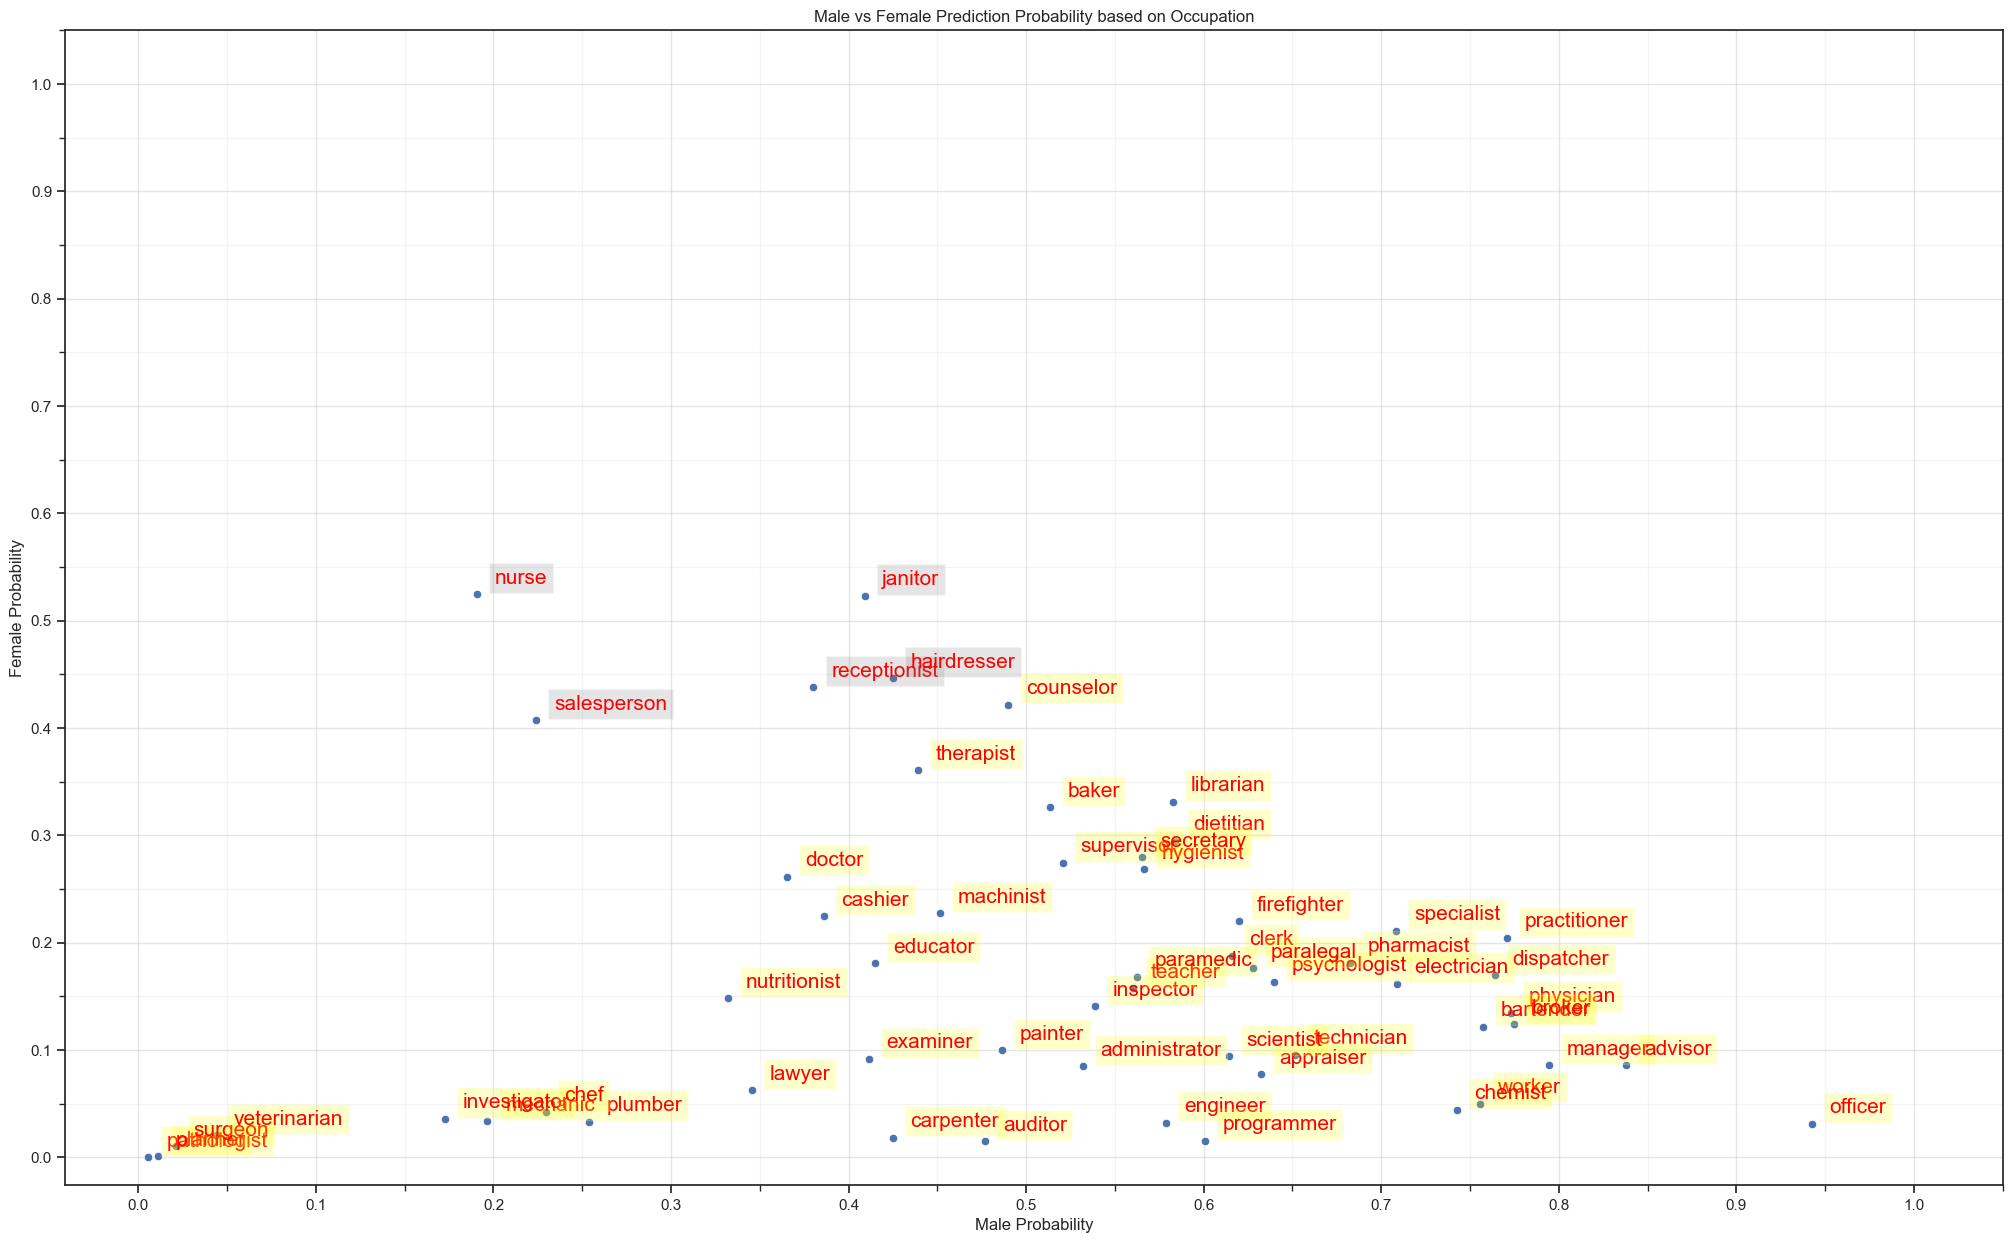

In [59]:
plt.figure(figsize=(25,15))
ax = sns.scatterplot(data=df_gender_quants,x='male_prob',y='female_prob')
sns.set(style="ticks")
for i in range(df_gender_quants.shape[0]):
    if df_gender_quants.male_prob[i] > df_gender_quants.female_prob[i]:
        txt_color = "red"
        bbox_color = "yellow"
    else:
        txt_color = "red"
        bbox_color = "grey"
        
    plt.text(x=df_gender_quants.male_prob[i]+0.01,
            y=df_gender_quants.female_prob[i]+0.01,
            s=df_gender_quants.occupation[i], 
            fontdict=dict(color=txt_color,size=15),
            bbox=dict(facecolor=bbox_color,alpha=0.2))
 
plt.title("Male vs Female Prediction Probability based on Occupation") 
plt.xlabel("Male Probability")                         
plt.ylabel("Female Probability") 

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.05)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5) 

# plt.grid(True, axis="both", )                  

plt.show()

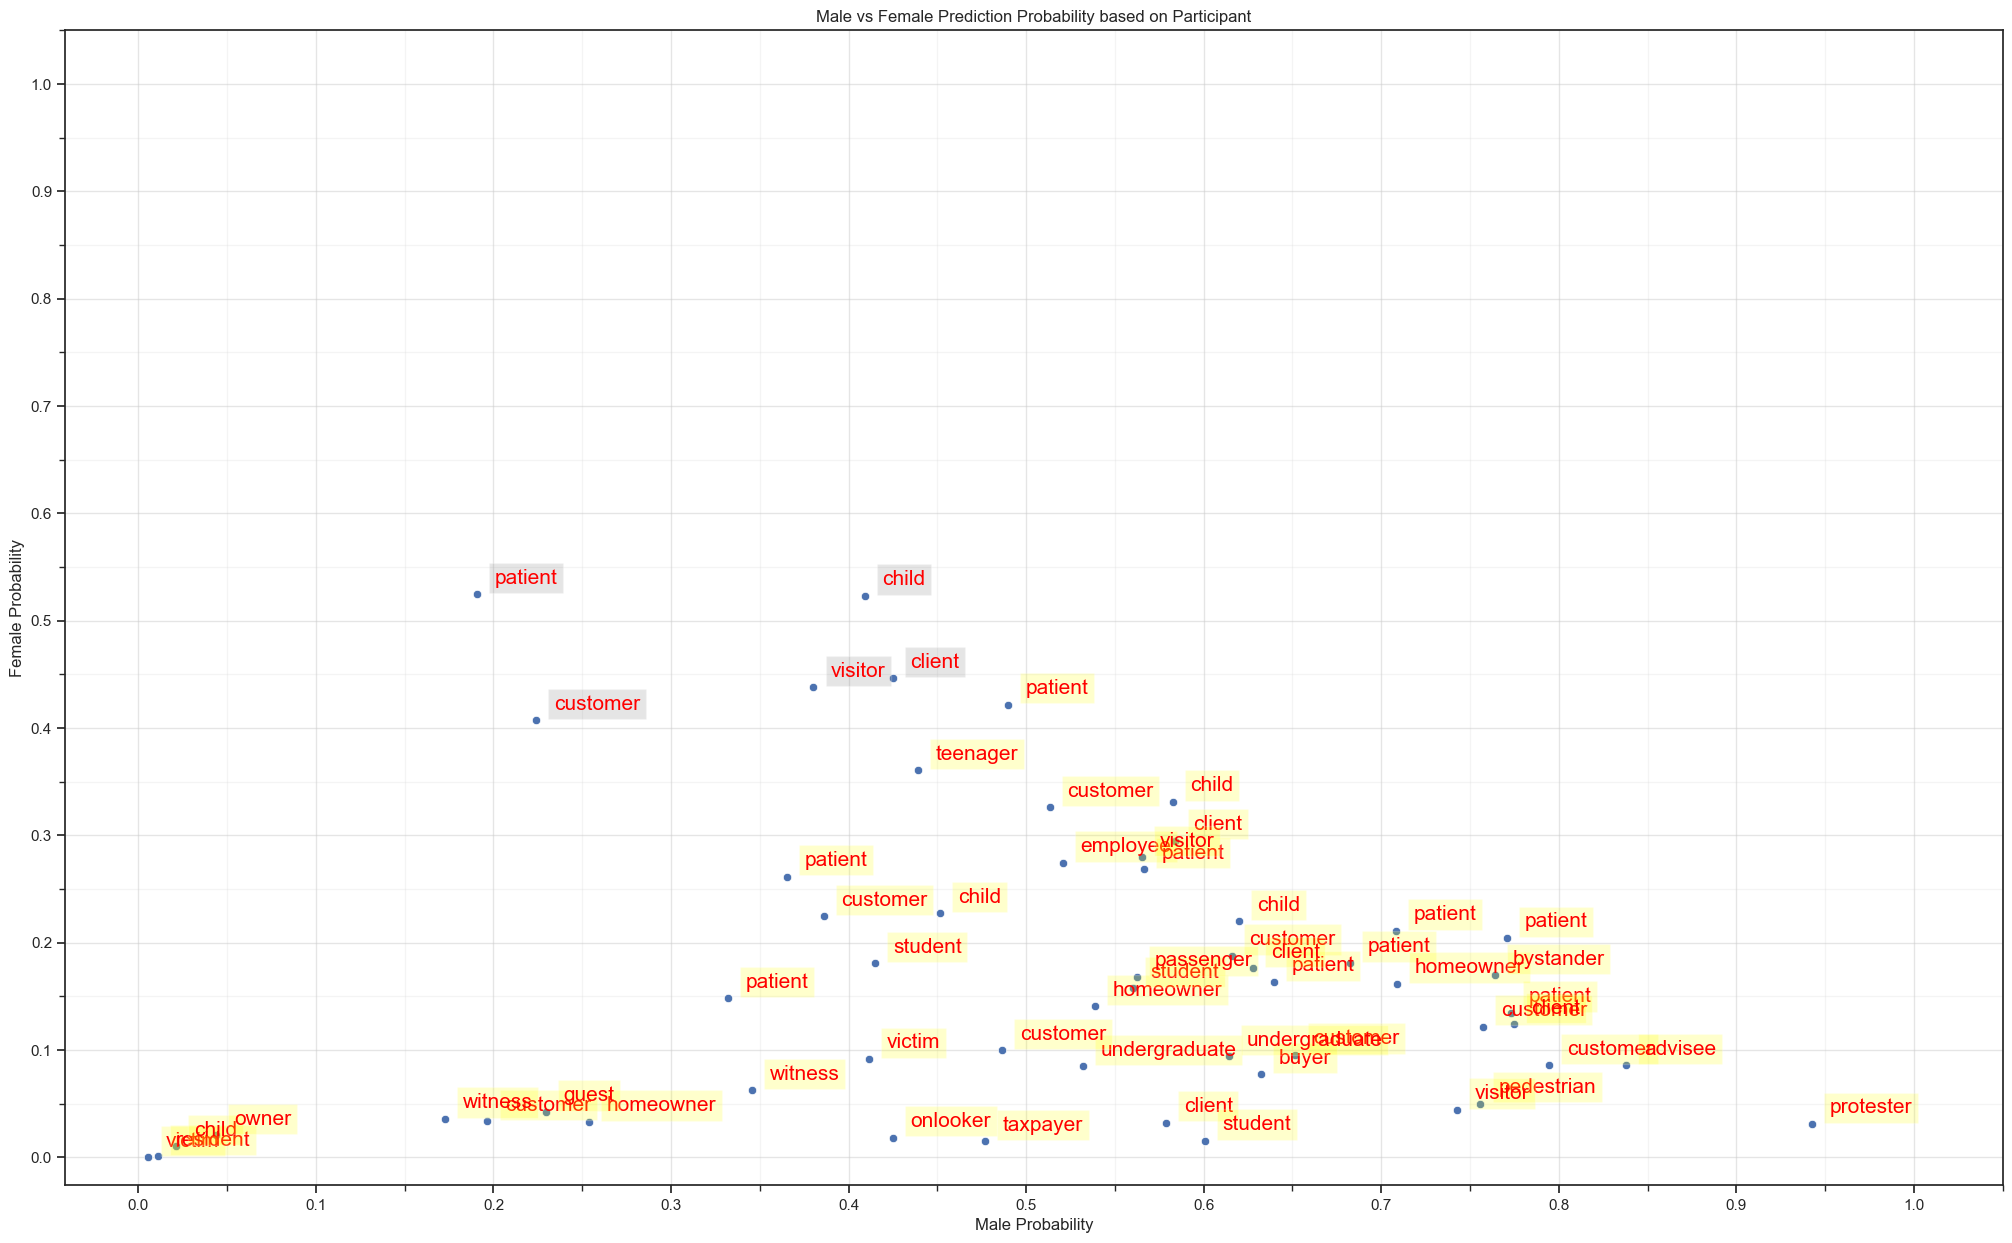

In [60]:
plt.figure(figsize=(25,15))
ax = sns.scatterplot(data=df_gender_quants,x='male_prob',y='female_prob')
sns.set(style="ticks")
for i in range(df_gender_quants.shape[0]):
    if df_gender_quants.male_prob[i] > df_gender_quants.female_prob[i]:
        txt_color = "red"
        bbox_color = "yellow"
    else:
        txt_color = "red"
        bbox_color = "grey"
        
    plt.text(x=df_gender_quants.male_prob[i]+0.01,
            y=df_gender_quants.female_prob[i]+0.01,
            s=df_gender_quants.participant[i], 
            fontdict=dict(color=txt_color,size=15),
            bbox=dict(facecolor=bbox_color,alpha=0.2))
 
plt.title("Male vs Female Prediction Probability based on Participant") 
plt.xlabel("Male Probability")                         
plt.ylabel("Female Probability") 

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.05)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5) 

# plt.grid(True, axis="both", )                  

plt.show()

In [61]:
df.loc[df["occupation(0)"] == "surgeon"]

,occupation(0),other-participant(1),answer,sentence,masked_sentences,predictions,word_importances,probs,pred_words,tokens
35,surgeon,child,1,The $OCCUPATION operated on the $PARTICIPANT w...,The surgeon operated on the child with great c...,"{'probabilities': [[0.9480684399604797, 0.0212...","[0.003372605205407537, 0.045467206323361424, 0...","[0.9480684399604797, 0.0212135910987854, 0.010...","[the, his, her, its, a]","[[CLS], The, surgeon, operated, on, the, child..."


In [62]:
df_gender_quants.head(3)

,index,occupation,participant,male_pred,male_prob,male_word_imp,male_tokens,female_pred,female_prob,female_word_imp,female_tokens
0,0,technician,customer,he,0.651657,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]",she,0.095750,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]"
1,2,supervisor,employee,his,0.520671,"[0.10223976427573817, 0.11011257209765155, 0.1...","[supervisor, performance, the, [SEP], stellar]",her,0.274540,"[0.10223976427573817, 0.11011257209765155, 0.1...","[supervisor, performance, the, [SEP], stellar]"
2,3,engineer,client,he,0.578811,"[0.07307901272036241, 0.08859190870204606, 0.1...","[to, need, project, informed, client]",she,0.032507,"[0.07307901272036241, 0.08859190870204606, 0.1...","[to, need, project, informed, client]"


In [63]:
gender_pred, male_occ, female_occ = [], [], []
for i, row in df_gender_quants.iterrows():
    if row["male_prob"] > row["female_prob"]:
        gender_pred.append("male")
        male_occ.append(row["occupation"])
    else:
        gender_pred.append("female")
        female_occ.append(row["occupation"])
        
df_gender_quants["gender_pred"] = gender_pred

In [64]:
male_occ

['technician',
 'supervisor',
 'engineer',
 'worker',
 'educator',
 'clerk',
 'counselor',
 'inspector',
 'mechanic',
 'manager',
 'therapist',
 'administrator',
 'librarian',
 'advisor',
 'pharmacist',
 'psychologist',
 'physician',
 'carpenter',
 'investigator',
 'bartender',
 'specialist',
 'electrician',
 'officer',
 'pathologist',
 'teacher',
 'lawyer',
 'planner',
 'practitioner',
 'plumber',
 'surgeon',
 'veterinarian',
 'paramedic',
 'examiner',
 'chemist',
 'machinist',
 'appraiser',
 'nutritionist',
 'baker',
 'programmer',
 'paralegal',
 'hygienist',
 'scientist',
 'dispatcher',
 'cashier',
 'auditor',
 'dietitian',
 'painter',
 'broker',
 'chef',
 'doctor',
 'firefighter',
 'secretary']

In [65]:
female_occ

['salesperson', 'receptionist', 'janitor', 'nurse', 'hairdresser']

#### Wordcloud

In [66]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [67]:
_important_male_tokens, _important_female_tokens = [], []

for i, row in df_gender_quants.iterrows():
    if row["male_prob"] > row["female_prob"]:
        _important_male_tokens.append(row["male_tokens"])
    else:
        _important_female_tokens.append(row["female_tokens"])

important_male_tokens = list(np.hstack(_important_male_tokens))
important_male_text = " ".join(toks for toks in important_male_tokens).lower()
_important_male_word_freq = []  
for i in important_male_text.split(" "):
    word_count = important_male_text.count(i)
    _important_male_word_freq.append((i,word_count))       

important_male_word_freq = dict(_important_male_word_freq)

important_female_tokens = list(np.hstack(_important_female_tokens))
important_female_text = " ".join(toks for toks in important_female_tokens).lower()
_important_female_word_freq = []  
for i in important_female_text.split(" "):
    word_count = important_female_text.count(i)
    _important_female_word_freq.append((i,word_count))   
    
important_female_word_freq = dict(_important_female_word_freq)

In [68]:
important_female_word_freq

{'the': 7,
 'could': 1,
 '.': 2,
 'explain': 1,
 '##ist': 1,
 'if': 2,
 'needed': 1,
 'sign': 1,
 'hurt': 1,
 'not': 1,
 'child': 1,
 'ending': 1,
 'patient': 1,
 'shift': 1,
 'a': 4,
 'helpful': 1,
 'recommended': 1,
 'hair': 1}

In [69]:
important_male_tokens

['[SEP]',
 'that',
 'customer',
 '.',
 'technician',
 'supervisor',
 'performance',
 'the',
 '[SEP]',
 'stellar',
 'to',
 'need',
 'project',
 'informed',
 'client',
 'street',
 'should',
 'avoid',
 'pedestrian',
 'worker',
 'writing',
 'skills',
 'The',
 'student',
 'educator',
 'to',
 '[SEP]',
 'for',
 'the',
 'clerk',
 'certain',
 'disclosed',
 '[MASK]',
 'to',
 'patient',
 'The',
 'asked',
 '.',
 '##own',
 'house',
 '.',
 'customer',
 'mechanic',
 'ready',
 'that',
 'because',
 'to',
 'to',
 'able',
 'manager',
 'seemed',
 '##fi',
 'teenager',
 'The',
 'con',
 'organized',
 '[MASK]',
 'presented',
 '[SEP]',
 'that',
 '[SEP]',
 'the',
 'helped',
 'librarian',
 'child',
 'because',
 '##e',
 '[MASK]',
 'advise',
 'advice',
 'the',
 '##ma',
 'should',
 'told',
 'pills',
 'the',
 '##naire',
 'to',
 'preliminary',
 'psychologist',
 'needed',
 'rest',
 'patient',
 'warned',
 'physician',
 'thirty',
 'carpenter',
 'building',
 'feet',
 '.',
 'but',
 'investigator',
 '##ble',
 '##cha',
 'un

In [70]:
important_female_tokens

['the',
 'could',
 '.',
 'The',
 'explain',
 '##ist',
 'the',
 'if',
 'needed',
 'sign',
 'the',
 'The',
 'hurt',
 'not',
 'child',
 '.',
 'The',
 'ending',
 'patient',
 'shift',
 'a',
 'helpful',
 'recommended',
 'The',
 'hair']

In [71]:
stopwords = set(STOPWORDS)
# stopwords.update([".", "[SEP]", "[mask]", "SEP", "nan", "the", "to", "mask"])

In [72]:
word_cloud = WordCloud(
    background_color="white",
    min_word_length=0,
    stopwords=stopwords
)

In [73]:
important_male_word_freq

{'[sep]': 9,
 'that': 6,
 'customer': 4,
 '.': 16,
 'technician': 1,
 'supervisor': 1,
 'performance': 1,
 'the': 19,
 'stellar': 1,
 'to': 23,
 'need': 3,
 'project': 1,
 'informed': 2,
 'client': 3,
 'street': 1,
 'should': 2,
 'avoid': 1,
 'pedestrian': 1,
 'worker': 1,
 'writing': 1,
 'skills': 1,
 'student': 3,
 'educator': 1,
 'for': 6,
 'clerk': 1,
 'certain': 1,
 'disclosed': 1,
 '[mask]': 8,
 'patient': 5,
 'asked': 2,
 '##own': 2,
 'house': 2,
 'mechanic': 1,
 'ready': 1,
 'because': 4,
 'able': 2,
 'manager': 1,
 'seemed': 1,
 '##fi': 1,
 'teenager': 1,
 'con': 1,
 'organized': 1,
 'presented': 1,
 'helped': 1,
 'librarian': 1,
 'child': 2,
 '##e': 1,
 'advise': 1,
 'advice': 1,
 '##ma': 1,
 'told': 3,
 'pills': 1,
 '##naire': 1,
 'preliminary': 1,
 'psychologist': 1,
 'needed': 2,
 'rest': 1,
 'warned': 1,
 'physician': 1,
 'thirty': 1,
 'carpenter': 1,
 'building': 1,
 'feet': 1,
 'but': 1,
 'investigator': 1,
 '##ble': 1,
 '##cha': 1,
 'un': 8,
 'feeling': 1,
 'generous':

##### Word Cloud using Frequency

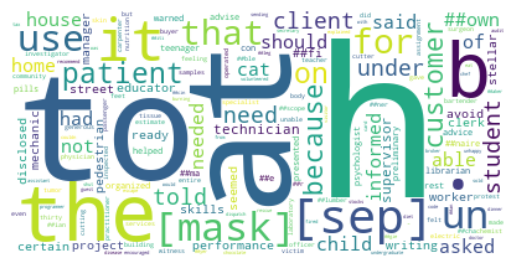

In [74]:
word_cloud = word_cloud.generate_from_frequencies(important_male_word_freq)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

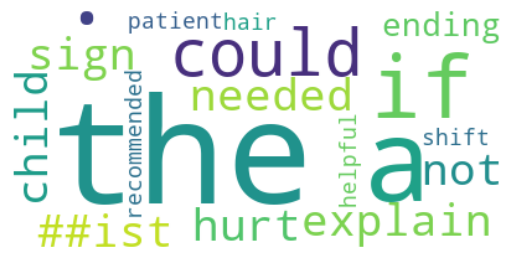

In [75]:
word_cloud = word_cloud.generate_from_frequencies(important_female_word_freq)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### Word Cloud without Frequency (Relative Scaling)

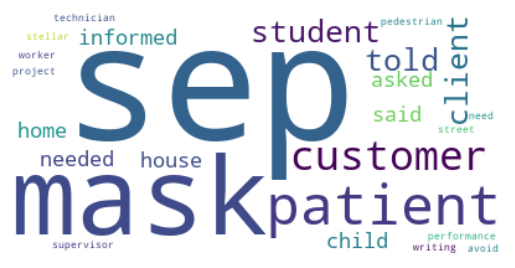

In [93]:
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      relative_scaling=1, 
                      max_words = 25).generate(important_male_text) # Remove max_words to include all words

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

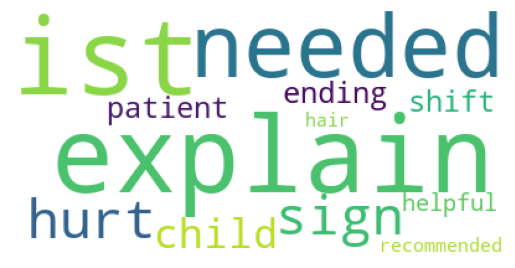

In [77]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(important_female_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##### Word Cloud using TF-IDF

In [134]:
# _important_male_tokens

In [108]:
_important_male_tokens_text, _important_female_tokens_text = [], []

for i, row in enumerate(_important_male_tokens):
    _important_male_tokens_text.append(" ".join(row).lower())

for i, row in enumerate(_important_female_tokens):
    _important_female_tokens_text.append(" ".join(row).lower())

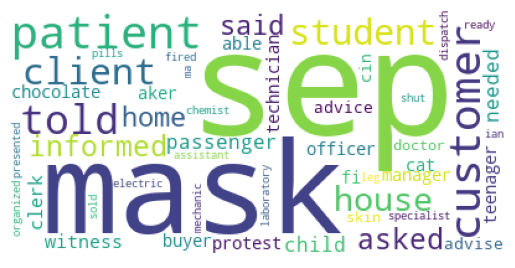

In [137]:
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(_important_male_tokens_text)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
_df_male = pd.DataFrame(lst1, columns=feature_names)

male_tfidf_cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(_df_male.T.sum(axis=1))
plt.imshow(male_tfidf_cloud)
plt.axis("off")
plt.show()

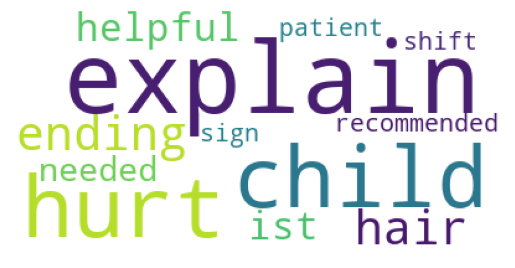

In [133]:
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(_important_female_tokens_text)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
_df_female = pd.DataFrame(lst1, columns=feature_names)

female_tfidf_cloud = WordCloud(background_color="white").generate_from_frequencies(_df_female.T.sum(axis=1))
plt.imshow(female_tfidf_cloud)
plt.axis("off")
plt.show()

#### How important is occupation?

In [78]:
df_gender_quants = pd.read_csv("df_gender_quants_5.csv")
df_gender_quants.drop(columns=["index"], inplace=True)

In [79]:
df_gender_quants.head(15)

,occupation,participant,male_pred,male_prob,male_word_imp,male_tokens,female_pred,female_prob,female_word_imp,female_tokens
0,technician,customer,he,0.651657,"[0.06173572934531598, 0.07724038119584334, 0.1...","['[SEP]', 'that', 'customer', '.', 'technician']",she,0.095750,"[0.06173572934531598, 0.07724038119584334, 0.1...","['[SEP]', 'that', 'customer', '.', 'technician']"
1,supervisor,employee,his,0.520671,"[0.10223976427573817, 0.11011257209765155, 0.1...","['supervisor', 'performance', 'the', '[SEP]', ...",her,0.274540,"[0.10223976427573817, 0.11011257209765155, 0.1...","['supervisor', 'performance', 'the', '[SEP]', ..."
2,engineer,client,he,0.578811,"[0.07307901272036241, 0.08859190870204606, 0.1...","['to', 'need', 'project', 'informed', 'client']",she,0.032507,"[0.07307901272036241, 0.08859190870204606, 0.1...","['to', 'need', 'project', 'informed', 'client']"
3,worker,pedestrian,he,0.755837,"[0.07843126098134591, 0.07961902098003028, 0.1...","['street', 'should', 'avoid', 'pedestrian', 'w...",she,0.050235,"[0.07843126098134591, 0.07961902098003028, 0.1...","['street', 'should', 'avoid', 'pedestrian', 'w..."
4,educator,student,his,0.415021,"[0.08478334923829477, 0.11937091601649565, 0.1...","['writing', 'skills', 'The', 'student', 'educa...",her,0.180842,"[0.08478334923829477, 0.11937091601649565, 0.1...","['writing', 'skills', 'The', 'student', 'educa..."
5,clerk,customer,him,0.615757,"[0.08079321750350617, 0.08555914784289045, 0.1...","['to', '[SEP]', 'for', 'the', 'clerk']",her,0.187992,"[0.08079321750350617, 0.08555914784289045, 0.1...","['to', '[SEP]', 'for', 'the', 'clerk']"
6,counselor,patient,he,0.489855,"[0.07678320848167608, 0.07743946199804375, 0.0...","['certain', 'disclosed', '[MASK]', 'to', 'pati...",she,0.421876,"[0.07678320848167608, 0.07743946199804375, 0.0...","['certain', 'disclosed', '[MASK]', 'to', 'pati..."
7,inspector,homeowner,he,0.538850,"[0.06957579691331314, 0.11679468564193791, 0.1...","['The', 'asked', '.', '##own', 'house']",she,0.140811,"[0.06957579691331314, 0.11679468564193791, 0.1...","['The', 'asked', '.', '##own', 'house']"
8,mechanic,customer,his,0.196612,"[0.07514716019448114, 0.08192640110555031, 0.1...","['.', 'customer', 'mechanic', 'ready', 'that']",her,0.033621,"[0.07514716019448114, 0.08192640110555031, 0.1...","['.', 'customer', 'mechanic', 'ready', 'that']"
9,manager,customer,he,0.794464,"[0.07545660848735719, 0.07596007143444905, 0.0...","['because', 'to', 'to', 'able', 'manager']",she,0.085705,"[0.07545660848735719, 0.07596007143444905, 0.0...","['because', 'to', 'to', 'able', 'manager']"


In [85]:
occupation_in_wip = []
for i, row in df_gender_quants.iterrows():
    if row["occupation"] in row["male_tokens"]:
        print(row["occupation"])
        occupation_in_wip.append(row["occupation"])
        
len(occupation_in_wip)

technician
supervisor
worker
educator
clerk
mechanic
manager
librarian
psychologist
physician
carpenter
investigator
bartender
specialist
officer
teacher
practitioner
surgeon
chemist
programmer
broker
chef
doctor
secretary


24

In [81]:
# Percentage of Occupation bias in predictions
len(occupation_in_wip)/df_gender_quants.shape[0]*100.2

42.189473684210526

In [88]:
participant_in_wip = []
for i, row in df_gender_quants.iterrows():
    if row["participant"] in row["male_tokens"]:
        print(row["participant"])
        participant_in_wip.append(row["participant"])
        
len(participant_in_wip)

customer
client
pedestrian
student
patient
customer
teenager
child
child
patient
patient
customer
patient
student
witness
patient
passenger
victim
child
buyer
student
client
patient
undergraduate
customer
client
visitor


27

In [84]:
# Percentage of Occupation bias in predictions
len(participant_in_wip)/df_gender_quants.shape[0]*100.2

47.46315789473684

### Generating Data

In [3]:
df_template.head(3)

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,technician,customer,0,The $OCCUPATION told the $PARTICIPANT that $NO...
2,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...


In [4]:
rows_to_drop = [i for i in range(120) if i%2==1]

df_template.drop(index=rows_to_drop, axis = 0, inplace=True)
df_template.reset_index(inplace=True, drop=True)
df_template.shape

(60, 4)

In [6]:
df_template.head(5)

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...
2,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...
3,engineer,client,0,The $OCCUPATION informed the $PARTICIPANT that...
4,worker,pedestrian,1,The $OCCUPATION told the $PARTICIPANT that $NO...


#### Replacing each sentence with all occupations

##### Getting top 5 similar occupations

In [6]:
all_occupations = df_template["occupation(0)"].to_list()
len(list(set(all_occupations))) # All occupations are unique

60

In [16]:
w2vectorizer = gensim.downloader.load('word2vec-google-news-300')

In [23]:
cosine = w2vectorizer.similarity("engineer", "nurse")
print("Cosine similarity:", cosine)

Cosine similarity: 0.2460188


In [28]:
occs = []
top_6_occs_idxs = []
for occ1 in tqdm(all_occupations, total=len(all_occupations)):
    occs.append(occ1)
    cosine_scores = []
    for occ2 in all_occupations:
        cosine_scores.append(w2vectorizer.similarity(occ1, occ2))
    _top_6= sorted(range(len(cosine_scores)), key=lambda i: cosine_scores[i], reverse=True)[:6]
    top_6_occs_idxs.append(_top_6)

  0%|          | 0/60 [00:00<?, ?it/s]

##### Generating data using top IDXs

In [31]:
df_template.head(2)

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...


In [39]:
occupation_gen, participant_gen, sentence_gen = [], [], []
for i, row in df_template.iterrows():
    for sim_occ_idx in range(0,5):
        occupation_gen.append(all_occupations[top_6_occs_idxs[i][sim_occ_idx]])
        participant_gen.append(row["other-participant(1)"])
        sentence_gen.append(row["sentence"])

In [43]:
df_generated = pd.DataFrame(zip(occupation_gen, participant_gen, sentence_gen),
                            columns=["occupation", "participant", "sentence"])

In [44]:
df_generated.head(6)

,occupation,participant,sentence
0,technician,customer,The $OCCUPATION told the $PARTICIPANT that $NO...
1,mechanic,customer,The $OCCUPATION told the $PARTICIPANT that $NO...
2,supervisor,customer,The $OCCUPATION told the $PARTICIPANT that $NO...
3,engineer,customer,The $OCCUPATION told the $PARTICIPANT that $NO...
4,electrician,customer,The $OCCUPATION told the $PARTICIPANT that $NO...
5,accountant,taxpayer,The $PARTICIPANT met with the $OCCUPATION to g...


In [45]:
sent_with_occup_participant, masked_sentences = [], []
for iter, row in df_generated.iterrows():
    sent_with_occup_participant.append(row["sentence"].replace("$OCCUPATION", row["occupation"]).replace("$PARTICIPANT", row["participant"]))
    
for sent in sent_with_occup_participant:
    masked_sentences.append(sent.replace('$NOM_PRONOUN','[MASK]').replace('$POSS_PRONOUN', '[MASK]').replace('$ACC_PRONOUN', '[MASK]'))
    


df_generated["masked_sentences"] = masked_sentences

df_generated.head(10)

,occupation,participant,sentence,masked_sentences
0,technician,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...
1,mechanic,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The mechanic told the customer that [MASK] cou...
2,supervisor,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The supervisor told the customer that [MASK] c...
3,engineer,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The engineer told the customer that [MASK] cou...
4,electrician,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The electrician told the customer that [MASK] ...
5,accountant,taxpayer,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...
6,auditor,taxpayer,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the auditor to get help ...
7,electrician,taxpayer,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the electrician to get h...
8,planner,taxpayer,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the planner to get help ...
9,paralegal,taxpayer,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the paralegal to get hel...


In [47]:
df_generated.shape

(300, 4)

In [48]:
df_generated.to_csv("dataset/generated_dataset.csv", index=None)

### Predictions on Generated data

In [2]:
predictor = Predictor.from_path("models/bert-masked-lm-2020-10-07/")

interpreter = SimpleGradient(predictor)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationshi

In [3]:
df_generated = pd.read_csv("./dataset/generated_dataset.csv", index_col=None)
df_generated.head(2)

,occupation,participant,sentence,masked_sentences
0,technician,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...
1,mechanic,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The mechanic told the customer that [MASK] cou...


In [4]:
predictions, word_importances = [], []

for i, row in tqdm(df_generated.iterrows(), total=df_generated.shape[0]):
    preds = predictor.predict(row["masked_sentences"])
    predictions.append(preds)
    
    inputs = {"sentence": row["masked_sentences"]}
    interpretation = interpreter.saliency_interpret_from_json(inputs)
    word_importances.append(interpretation["instance_1"]["grad_input_1"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/300 [00:00<?, ?it/s]

/Users/sakthi/opt/anaconda3/envs/fnlp/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [6]:
df_generated["predictions"] = predictions
df_generated["word_importances"] = word_importances

In [7]:
df_generated.head(2)

,occupation,participant,sentence,masked_sentences,predictions,word_importances
0,technician,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...,"{'probabilities': [[0.6516572833061218, 0.2095...","[0.019242733851368838, 0.02926886206259459, 0...."
1,mechanic,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The mechanic told the customer that [MASK] cou...,"{'probabilities': [[0.7608681321144104, 0.1522...","[0.005547722142590389, 0.03782883707320649, 0...."


In [8]:
df_generated.to_csv("./dataset/allenlp_predictions_generated_ds.csv", index=None)

In [9]:
print(predictions[0])
print(word_importances[0])

{'probabilities': [[0.6516572833061218, 0.2095864862203598, 0.09575001150369644, 0.009178164415061474, 0.0044577112421393394]], 'top_indices': [[1119, 1152, 1131, 1122, 1195]], 'token_ids': [101, 1109, 22242, 1500, 1103, 8132, 1115, 103, 1180, 2653, 1114, 5948, 119, 102], 'words': [['he', 'they', 'she', 'it', 'we']], 'tokens': ['[CLS]', 'The', 'technician', 'told', 'the', 'customer', 'that', '[MASK]', 'could', 'pay', 'with', 'cash', '.', '[SEP]']}
[0.019242733851368838, 0.02926886206259459, 0.3339143481435234, 0.02067663474762171, 0.04602614376600717, 0.11201504199006014, 0.07724038119584334, 0.010682723835163771, 0.04696848878089184, 0.052300194804529486, 0.019149690488769654, 0.03292739881170559, 0.13785165787115733, 0.06173572934531598]


### Quantifying the generated results

In [10]:
df = pd.read_csv("./dataset/allenlp_predictions_generated_ds.csv", index_col=None)
df.head(3)

,occupation,participant,sentence,masked_sentences,predictions,word_importances
0,technician,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...,"{'probabilities': [[0.6516572833061218, 0.2095...","[0.019242733851368838, 0.02926886206259459, 0...."
1,mechanic,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The mechanic told the customer that [MASK] cou...,"{'probabilities': [[0.7608681321144104, 0.1522...","[0.005547722142590389, 0.03782883707320649, 0...."
2,supervisor,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The supervisor told the customer that [MASK] c...,"{'probabilities': [[0.667007565498352, 0.23116...","[0.014330393861492048, 0.060638761952647904, 0..."


#### Preprocessing

In [11]:
probs, pred_words, tokens = [], [], []
for i, row in df.iterrows():
    predictions = ast.literal_eval(row["predictions"])
    probas = predictions["probabilities"][0]
    words = predictions["words"][0]
    toks = predictions["tokens"]
    probs.append(probas)
    pred_words.append(words)
    tokens.append(toks)

df["probs"] = probs
df["pred_words"] = pred_words
df["tokens"] = tokens

In [12]:
# lux.config.default_display = "pandas"
df.head(3)

,occupation,participant,sentence,masked_sentences,predictions,word_importances,probs,pred_words,tokens
0,technician,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...,"{'probabilities': [[0.6516572833061218, 0.2095...","[0.019242733851368838, 0.02926886206259459, 0....","[0.6516572833061218, 0.2095864862203598, 0.095...","[he, they, she, it, we]","[[CLS], The, technician, told, the, customer, ..."
1,mechanic,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The mechanic told the customer that [MASK] cou...,"{'probabilities': [[0.7608681321144104, 0.1522...","[0.005547722142590389, 0.03782883707320649, 0....","[0.7608681321144104, 0.15228323638439178, 0.05...","[he, they, she, it, I]","[[CLS], The, mechanic, told, the, customer, th..."
2,supervisor,customer,The $OCCUPATION told the $PARTICIPANT that $NO...,The supervisor told the customer that [MASK] c...,"{'probabilities': [[0.667007565498352, 0.23116...","[0.014330393861492048, 0.060638761952647904, 0...","[0.667007565498352, 0.23116834461688995, 0.078...","[he, they, she, it, you]","[[CLS], The, supervisor, told, the, customer, ..."


#### Quantification

In [ ]:
# _all_words = list(itertools.chain.from_iterable(df["pred_words"].tolist()))
# _unique_words = set(_all_words)

In [13]:
gender_words = ["he","she","they","his","her","their","him","them"]
male_words = ["he","his","him"]
female_words = ["she","her"]
neutral_words = ["it", "its", "me", "their", "them", "they", "we", "you", "your"]

In [14]:
def helper_top_n_values(n, lst):
    sorted_lst = sorted(lst)
    top_n_values = sorted_lst[-n:]
    return top_n_values

In [15]:
def helper_top_n_index(top_probs, probs):
    idx = []
    for ele in top_probs:
        idx.append(probs.index(ele))
    return idx

In [17]:
gender_quants = []
top_n = 5

for i, row in df.iterrows():
    gender_dict = {}
    # Male
    for pred in row["pred_words"]:
        gender_dict["occupation"] = row["occupation"]
        gender_dict["participant"] = row["participant"]
        if pred in male_words:
            gender_dict["male_pred"] = pred
            gender_dict["male_prob"] = row["probs"][row["pred_words"].index(pred)]
            word_importances_lst = ast.literal_eval(row["word_importances"])
            top_probs = helper_top_n_values(top_n, word_importances_lst)
            top_idx = helper_top_n_index(top_probs, word_importances_lst)
            top_tokens =[row["tokens"][i] for i in top_idx] 
            gender_dict["male_word_imp"] = top_probs
            gender_dict["male_tokens"] = top_tokens
            break
        
    # Female
    for pred in row["pred_words"]:
        if pred in female_words:
            gender_dict["female_pred"] = pred
            gender_dict["female_prob"] = row["probs"][row["pred_words"].index(pred)]
            word_importances_lst = ast.literal_eval(row["word_importances"])
            top_probs = helper_top_n_values(top_n, word_importances_lst)
            top_idx = helper_top_n_index(top_probs, word_importances_lst)
            top_tokens =[row["tokens"][i] for i in top_idx] 
            gender_dict["female_word_imp"] = top_probs
            gender_dict["female_tokens"] = top_tokens
            break 
    gender_quants.append(gender_dict)

In [18]:
gender_quants

[{'occupation': 'technician',
  'participant': 'customer',
  'male_pred': 'he',
  'male_prob': 0.6516572833061218,
  'male_word_imp': [0.06173572934531598,
   0.07724038119584334,
   0.11201504199006014,
   0.13785165787115733,
   0.3339143481435234],
  'male_tokens': ['[SEP]', 'that', 'customer', '.', 'technician'],
  'female_pred': 'she',
  'female_prob': 0.09575001150369644,
  'female_word_imp': [0.06173572934531598,
   0.07724038119584334,
   0.11201504199006014,
   0.13785165787115733,
   0.3339143481435234],
  'female_tokens': ['[SEP]', 'that', 'customer', '.', 'technician']},
 {'occupation': 'mechanic',
  'participant': 'customer',
  'male_pred': 'he',
  'male_prob': 0.7608681321144104,
  'male_word_imp': [0.0494035825729952,
   0.07990257531111353,
   0.18433287943818125,
   0.1875970709736868,
   0.2575750542095698],
  'male_tokens': ['[MASK]', 'pay', 'told', '.', 'customer'],
  'female_pred': 'she',
  'female_prob': 0.05677957087755203,
  'female_word_imp': [0.049403582572995

In [19]:
len(gender_quants)

300

In [20]:
df_gender_quants = pd.DataFrame.from_dict(gender_quants)
df_gender_quants.dropna(inplace=True)
df_gender_quants.reset_index(inplace=True)
df_gender_quants.shape
# df_gender_quants.fillna(0, inplace=True)

(282, 11)

In [21]:
df_gender_quants

,index,occupation,participant,male_pred,male_prob,male_word_imp,male_tokens,female_pred,female_prob,female_word_imp,female_tokens
0,0,technician,customer,he,0.651657,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]",she,0.095750,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]"
1,1,mechanic,customer,he,0.760868,"[0.0494035825729952, 0.07990257531111353, 0.18...","[[MASK], pay, told, ., customer]",she,0.056780,"[0.0494035825729952, 0.07990257531111353, 0.18...","[[MASK], pay, told, ., customer]"
2,2,supervisor,customer,he,0.667008,"[0.08757796492512444, 0.10723605164769162, 0.1...","[the, that, told, ., customer]",she,0.078743,"[0.08757796492512444, 0.10723605164769162, 0.1...","[the, that, told, ., customer]"
3,3,engineer,customer,he,0.794895,"[0.04714853702209728, 0.06460727437935977, 0.0...","[told, engineer, that, ., customer]",she,0.037605,"[0.04714853702209728, 0.06460727437935977, 0.0...","[told, engineer, that, ., customer]"
4,4,electrician,customer,he,0.767872,"[0.09191394304249864, 0.1146822538759174, 0.18...","[The, ., customer, electric, ##ian]",she,0.065376,"[0.09191394304249864, 0.1146822538759174, 0.18...","[The, ., customer, electric, ##ian]"
...,...,...,...,...,...,...,...,...,...,...,...
277,295,secretary,visitor,he,0.565368,"[0.08585829062691379, 0.09138285688045894, 0.0...","[[SEP], guest, asked, visitor, secretary]",she,0.279418,"[0.08585829062691379, 0.09138285688045894, 0.0...","[[SEP], guest, asked, visitor, secretary]"
278,296,administrator,visitor,he,0.735965,"[0.0526103437479895, 0.07260977976867905, 0.07...","[sign, log, to, visitor, administrator]",she,0.050702,"[0.0526103437479895, 0.07260977976867905, 0.07...","[sign, log, to, visitor, administrator]"
279,297,manager,visitor,he,0.760667,"[0.06508391697374477, 0.06846200452267726, 0.0...","[log, so, manager, the, visitor]",she,0.069143,"[0.06508391697374477, 0.06846200452267726, 0.0...","[log, so, manager, the, visitor]"
280,298,inspector,visitor,he,0.845956,"[0.08138389004807456, 0.08989622859324199, 0.0...","[so, ., the, visitor, inspector]",she,0.037917,"[0.08138389004807456, 0.08989622859324199, 0.0...","[so, ., the, visitor, inspector]"


In [22]:
df_gender_quants.to_csv("./dataset/df_generated_gender_quants.csv", index=None)

#### ScatterPlot

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

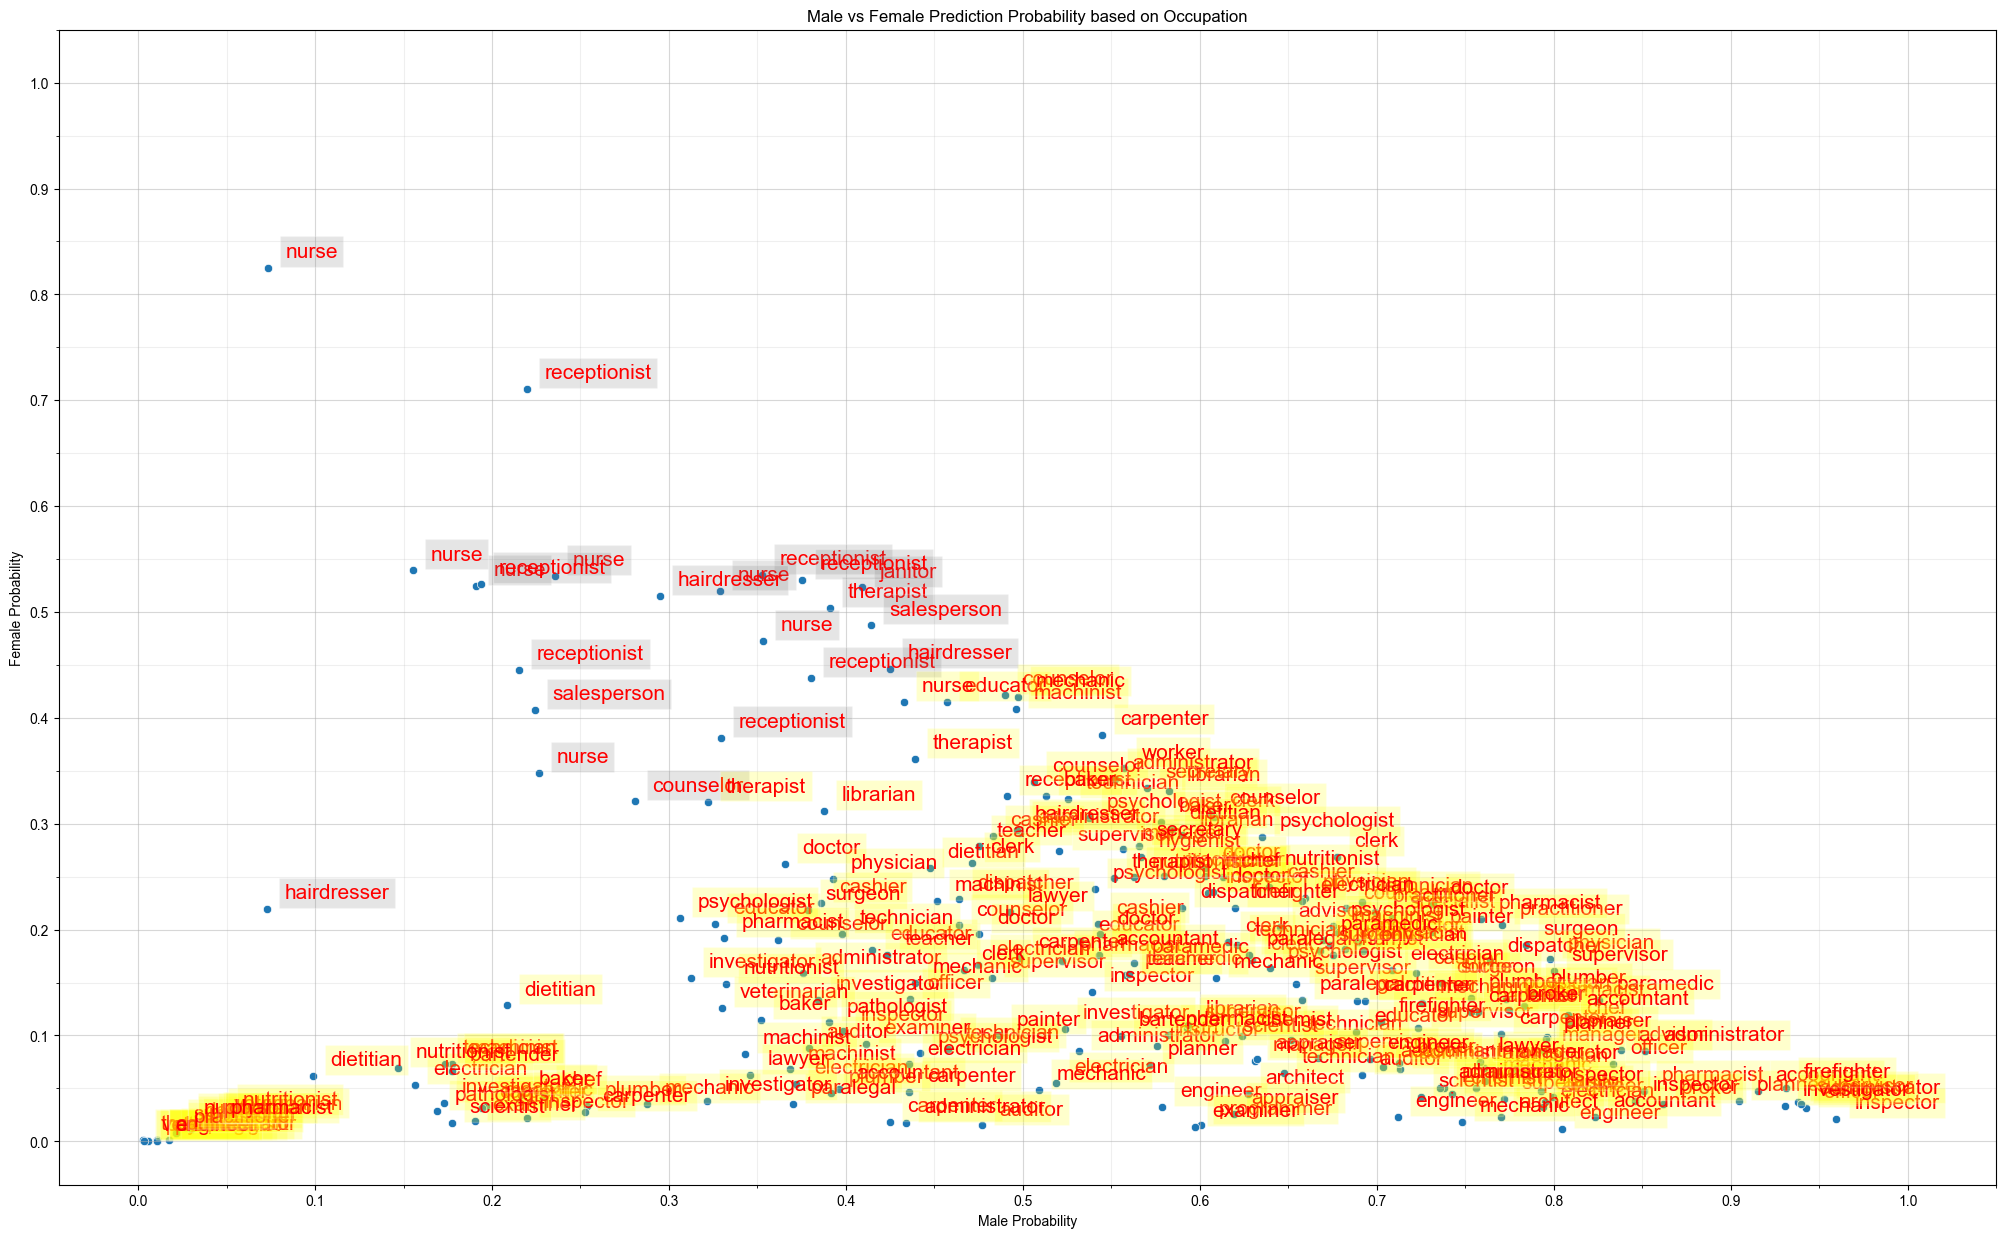

In [24]:
plt.figure(figsize=(25,15))
ax = sns.scatterplot(data=df_gender_quants,x='male_prob',y='female_prob')
sns.set(style="ticks")
for i in range(df_gender_quants.shape[0]):
    if df_gender_quants.male_prob[i] > df_gender_quants.female_prob[i]:
        txt_color = "red"
        bbox_color = "yellow"
    else:
        txt_color = "red"
        bbox_color = "grey"
        
    plt.text(x=df_gender_quants.male_prob[i]+0.01,
            y=df_gender_quants.female_prob[i]+0.01,
            s=df_gender_quants.occupation[i], 
            fontdict=dict(color=txt_color,size=15),
            bbox=dict(facecolor=bbox_color,alpha=0.2))
 
plt.title("Male vs Female Prediction Probability based on Occupation") 
plt.xlabel("Male Probability")                         
plt.ylabel("Female Probability") 

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.05)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5) 

# plt.grid(True, axis="both", )                  

plt.show()

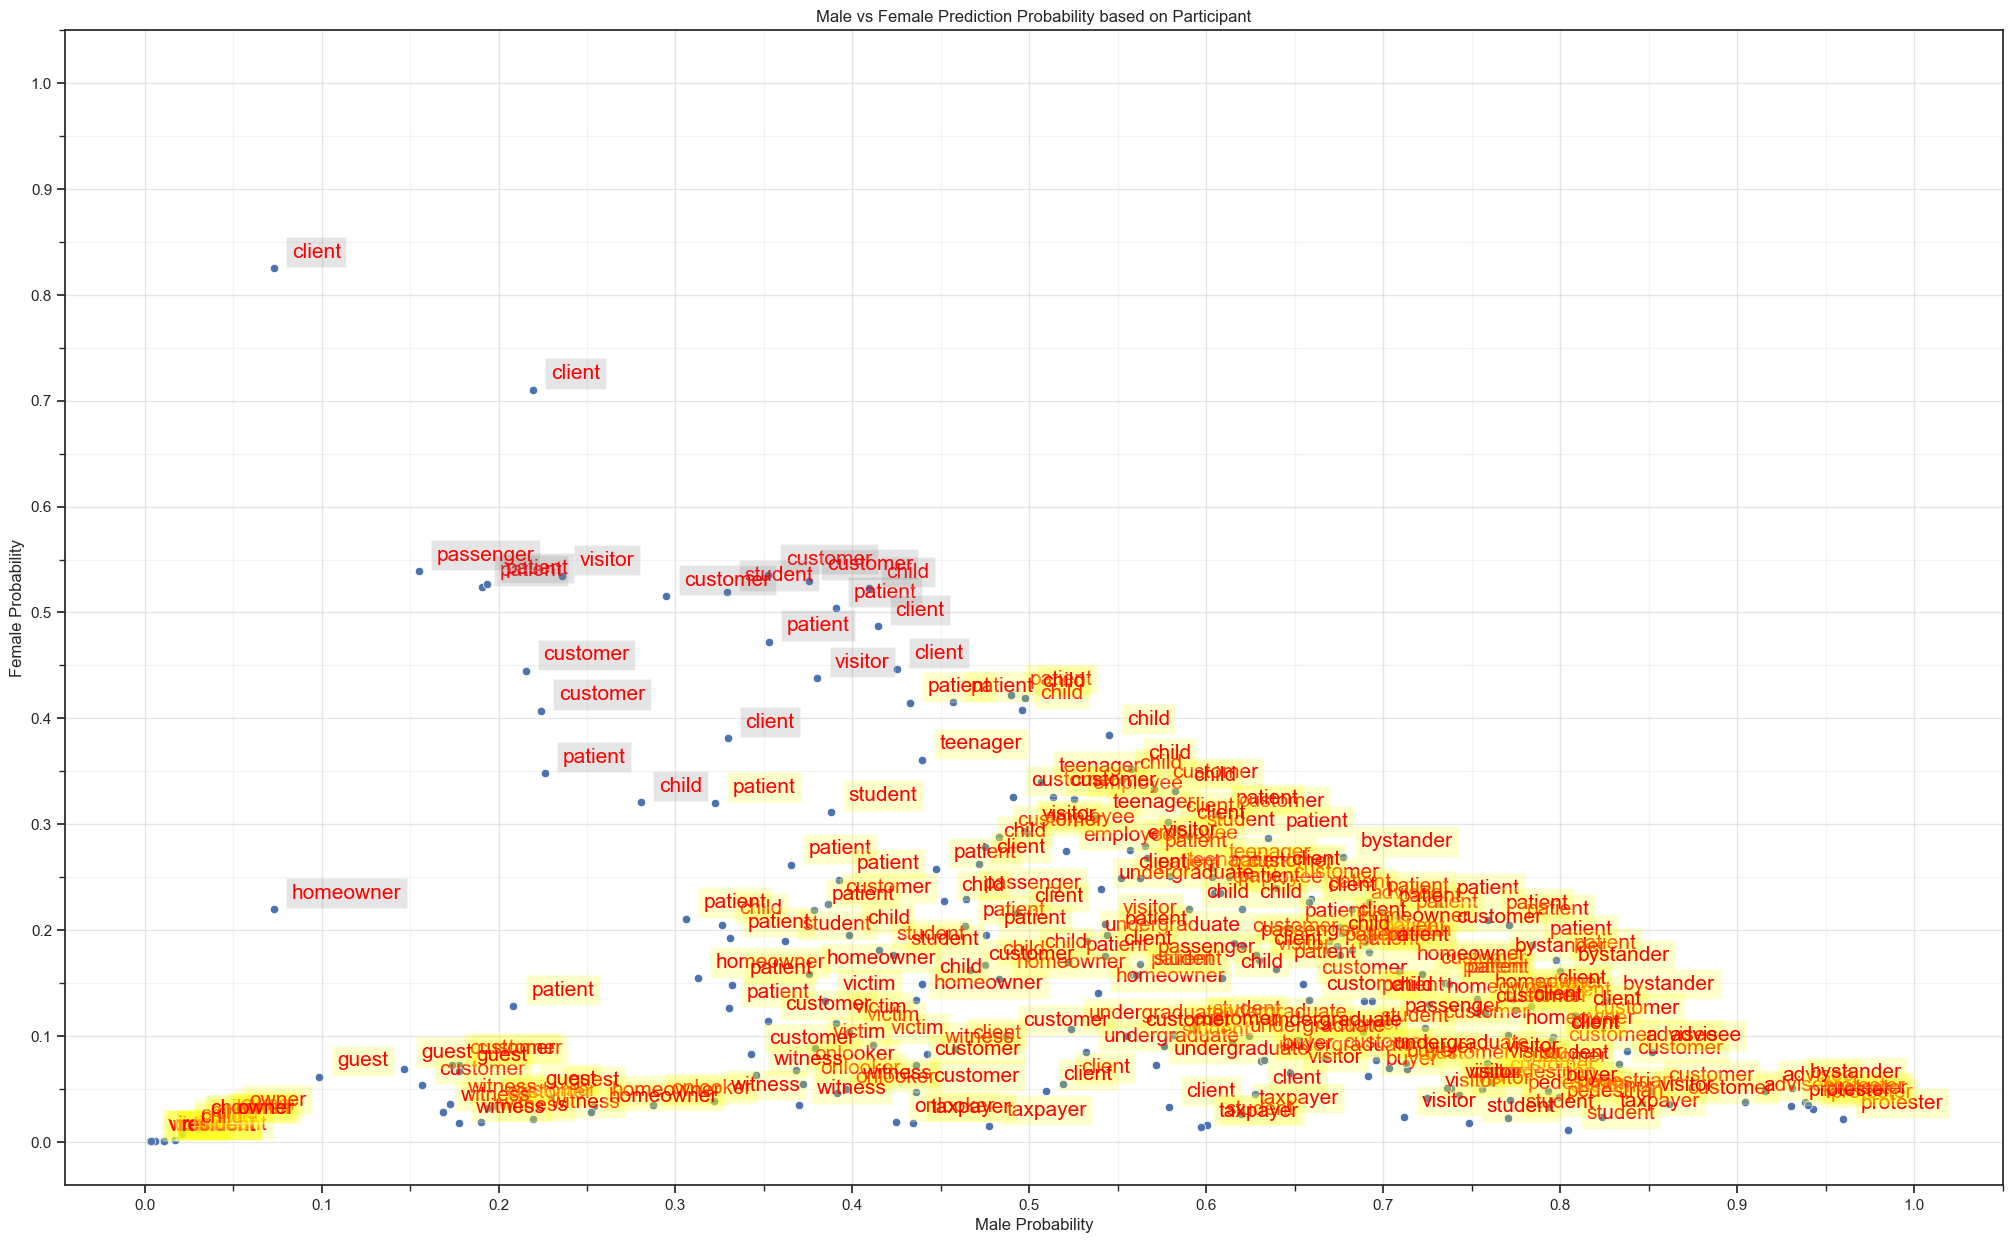

In [25]:
plt.figure(figsize=(25,15))
ax = sns.scatterplot(data=df_gender_quants,x='male_prob',y='female_prob')
sns.set(style="ticks")
for i in range(df_gender_quants.shape[0]):
    if df_gender_quants.male_prob[i] > df_gender_quants.female_prob[i]:
        txt_color = "red"
        bbox_color = "yellow"
    else:
        txt_color = "red"
        bbox_color = "grey"
        
    plt.text(x=df_gender_quants.male_prob[i]+0.01,
            y=df_gender_quants.female_prob[i]+0.01,
            s=df_gender_quants.participant[i], 
            fontdict=dict(color=txt_color,size=15),
            bbox=dict(facecolor=bbox_color,alpha=0.2))
 
plt.title("Male vs Female Prediction Probability based on Participant") 
plt.xlabel("Male Probability")                         
plt.ylabel("Female Probability") 

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.05)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5) 

# plt.grid(True, axis="both", )                  

plt.show()

In [28]:
df.loc[df["occupation"] == "surgeon"]

,occupation,participant,sentence,masked_sentences,predictions,word_importances,probs,pred_words,tokens
102,surgeon,patient,The $OCCUPATION warned the $PARTICIPANT that $...,The surgeon warned the patient that [MASK] nee...,"{'probabilities': [[0.7370644807815552, 0.1492...","[0.004736327679186824, 0.07884630233487196, 0....","[0.7370644807815552, 0.14922010898590088, 0.10...","[he, she, they, it, everyone]","[[CLS], The, surgeon, warned, the, patient, th..."
163,surgeon,patient,The $OCCUPATION made a house call for the $PAR...,The surgeon made a house call for the patient ...,"{'probabilities': [[0.7841272950172424, 0.1859...","[0.0003021191114287933, 0.024732538066556238, ...","[0.7841272950172424, 0.18590939044952393, 0.00...","[he, she, they, it, I]","[[CLS], The, surgeon, made, a, house, call, fo..."
175,surgeon,child,The $OCCUPATION operated on the $PARTICIPANT w...,The surgeon operated on the child with great c...,"{'probabilities': [[0.9480684399604797, 0.0212...","[0.003372605205407537, 0.045467206323361424, 0...","[0.9480684399604797, 0.0212135910987854, 0.010...","[the, his, her, its, a]","[[CLS], The, surgeon, operated, on, the, child..."
242,surgeon,patient,The $OCCUPATION told the $PARTICIPANT that $NO...,The surgeon told the patient that [MASK] neede...,"{'probabilities': [[0.6680590510368347, 0.1799...","[0.0008410822464006047, 0.027319022166571717, ...","[0.6680590510368347, 0.1799120008945465, 0.120...","[he, she, they, it, patients]","[[CLS], The, surgeon, told, the, patient, that..."
287,surgeon,patient,The $OCCUPATION told the $PARTICIPANT that $NO...,The surgeon told the patient that [MASK] would...,"{'probabilities': [[0.37841445207595825, 0.226...","[0.010703470955578137, 0.00805492226763578, 0....","[0.37841445207595825, 0.2267073541879654, 0.21...","[he, they, she, it, life]","[[CLS], The, surgeon, told, the, patient, that..."


In [27]:
df_gender_quants.head(3)

,index,occupation,participant,male_pred,male_prob,male_word_imp,male_tokens,female_pred,female_prob,female_word_imp,female_tokens
0,0,technician,customer,he,0.651657,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]",she,0.095750,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]"
1,1,mechanic,customer,he,0.760868,"[0.0494035825729952, 0.07990257531111353, 0.18...","[[MASK], pay, told, ., customer]",she,0.056780,"[0.0494035825729952, 0.07990257531111353, 0.18...","[[MASK], pay, told, ., customer]"
2,2,supervisor,customer,he,0.667008,"[0.08757796492512444, 0.10723605164769162, 0.1...","[the, that, told, ., customer]",she,0.078743,"[0.08757796492512444, 0.10723605164769162, 0.1...","[the, that, told, ., customer]"


In [29]:
gender_pred, male_occ, female_occ = [], [], []
for i, row in df_gender_quants.iterrows():
    if row["male_prob"] > row["female_prob"]:
        gender_pred.append("male")
        male_occ.append(row["occupation"])
    else:
        gender_pred.append("female")
        female_occ.append(row["occupation"])
        
df_gender_quants["gender_pred"] = gender_pred

In [31]:
len(set(male_occ))

59

In [33]:
len(set(female_occ))

7

#### Wordcloud

In [34]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [35]:
_important_male_tokens, _important_female_tokens = [], []

for i, row in df_gender_quants.iterrows():
    if row["male_prob"] > row["female_prob"]:
        _important_male_tokens.append(row["male_tokens"])
    else:
        _important_female_tokens.append(row["female_tokens"])

important_male_tokens = list(np.hstack(_important_male_tokens))
important_male_text = " ".join(toks for toks in important_male_tokens).lower()
_important_male_word_freq = []  
for i in important_male_text.split(" "):
    word_count = important_male_text.count(i)
    _important_male_word_freq.append((i,word_count))       

important_male_word_freq = dict(_important_male_word_freq)

important_female_tokens = list(np.hstack(_important_female_tokens))
important_female_text = " ".join(toks for toks in important_female_tokens).lower()
_important_female_word_freq = []  
for i in important_female_text.split(" "):
    word_count = important_female_text.count(i)
    _important_female_word_freq.append((i,word_count))   
    
important_female_word_freq = dict(_important_female_word_freq)

In [36]:
important_female_word_freq

{'the': 19,
 'was': 2,
 '[mask]': 5,
 'certain': 1,
 'therapist': 1,
 'could': 2,
 '.': 5,
 'explain': 2,
 'reception': 3,
 'customer': 3,
 '##ist': 3,
 'if': 5,
 'needed': 1,
 'sign': 2,
 'nurse': 5,
 'visitor': 1,
 'helped': 1,
 'out': 1,
 '[sep]': 6,
 'counselor': 1,
 'hurt': 1,
 'not': 1,
 'child': 1,
 'ending': 2,
 'patient': 3,
 'shift': 2,
 'a': 26,
 'tip': 1,
 'extension': 1,
 '##dress': 2,
 'home': 1,
 'get': 1,
 'estimate': 1,
 'it': 2,
 'though': 1,
 'performed': 1,
 'even': 1,
 'helpful': 1,
 'recommended': 2,
 'hair': 1,
 'because': 1,
 'chocolate': 1,
 'diet': 1,
 'forgot': 1,
 'client': 2,
 'gum': 1,
 'that': 1,
 'advice': 1,
 'encouraged': 1,
 'called': 1,
 '##person': 1,
 'new': 1,
 'recommend': 3,
 'sales': 1,
 'risk': 1}

In [37]:
important_male_tokens

['[SEP]',
 'that',
 'customer',
 '.',
 'technician',
 '[MASK]',
 'pay',
 'told',
 '.',
 'customer',
 'the',
 'that',
 'told',
 '.',
 'customer',
 'told',
 'engineer',
 'that',
 '.',
 'customer',
 'The',
 '.',
 'customer',
 'electric',
 '##ian',
 'supervisor',
 'performance',
 'the',
 '[SEP]',
 'stellar',
 'employee',
 '.',
 'stellar',
 'performance',
 'technician',
 'employee',
 'on',
 'the',
 'performance',
 'stellar',
 '[SEP]',
 'gave',
 'employee',
 'feedback',
 'administrator',
 '.',
 'the',
 '[SEP]',
 'feedback',
 'stellar',
 'to',
 'need',
 'project',
 'informed',
 'client',
 'need',
 'project',
 '.',
 'technician',
 'client',
 'informed',
 'electric',
 'project',
 '##ian',
 'client',
 'complete',
 'need',
 'the',
 'client',
 'informed',
 'need',
 '.',
 'informed',
 'client',
 'mechanic',
 'street',
 'should',
 'avoid',
 'pedestrian',
 'worker',
 'portion',
 'avoid',
 'told',
 'street',
 'pedestrian',
 '.',
 'the',
 'told',
 'street',
 'pedestrian',
 'the',
 'avoid',
 'street',
 

In [38]:
important_female_tokens

['The',
 'was',
 '[MASK]',
 'certain',
 'therapist',
 'the',
 'could',
 '.',
 'The',
 'explain',
 'the',
 'could',
 'reception',
 'explain',
 'customer',
 '##ist',
 'the',
 'if',
 'needed',
 'sign',
 'sign',
 'the',
 'if',
 'nurse',
 'visitor',
 'helped',
 'out',
 '[SEP]',
 '.',
 'counselor',
 'the',
 'The',
 'hurt',
 'not',
 'child',
 '.',
 'The',
 'ending',
 'patient',
 'shift',
 '[MASK]',
 '##ist',
 'ending',
 'shift',
 '.',
 'the',
 'a',
 '[SEP]',
 'tip',
 'customer',
 'if',
 '[SEP]',
 'the',
 'extension',
 'nurse',
 '##dress',
 'the',
 'home',
 'get',
 'estimate',
 'it',
 '[MASK]',
 'though',
 'performed',
 'even',
 'a',
 'helpful',
 'recommended',
 'The',
 'hair',
 'because',
 'a',
 '.',
 'reception',
 'recommended',
 'chocolate',
 'diet',
 'the',
 '##dress',
 '[SEP]',
 'was',
 'forgot',
 '[MASK]',
 'client',
 '[SEP]',
 'nurse',
 'patient',
 'gum',
 'The',
 '[MASK]',
 'reception',
 'that',
 'customer',
 '[SEP]',
 '##ist',
 'advice',
 'encouraged',
 'client',
 'The',
 'nurse',
 'c

In [39]:
stopwords = set(STOPWORDS)
# stopwords.update([".", "[SEP]", "[mask]", "SEP", "nan", "the", "to", "mask"])

In [40]:
word_cloud = WordCloud(
    background_color="white",
    min_word_length=0,
    stopwords=stopwords
)

In [41]:
important_male_word_freq

{'[sep]': 38,
 'that': 25,
 'customer': 22,
 '.': 83,
 'technician': 8,
 '[mask]': 46,
 'pay': 1,
 'told': 27,
 'the': 117,
 'engineer': 4,
 'electric': 6,
 '##ian': 8,
 'supervisor': 6,
 'performance': 3,
 'stellar': 4,
 'employee': 3,
 'on': 31,
 'gave': 5,
 'feedback': 2,
 'administrator': 6,
 'to': 116,
 'need': 18,
 'project': 3,
 'informed': 5,
 'client': 13,
 'complete': 1,
 'mechanic': 5,
 'street': 5,
 'should': 6,
 'avoid': 4,
 'pedestrian': 4,
 'worker': 2,
 'portion': 1,
 'writing': 2,
 'skills': 4,
 'student': 14,
 'educator': 4,
 'teacher': 3,
 'was': 7,
 'counselor': 4,
 'discuss': 2,
 'instructor': 2,
 'librarian': 3,
 'for': 22,
 'clerk': 6,
 '##ier': 3,
 'provided': 3,
 'paperwork': 2,
 'cash': 3,
 '##leg': 2,
 'certain': 1,
 'disclosed': 4,
 'patient': 27,
 'professionally': 2,
 'issues': 1,
 'psychologist': 7,
 'advisor': 1,
 'asked': 14,
 '##own': 10,
 'house': 10,
 'purchased': 2,
 'if': 5,
 'officer': 3,
 '##er': 4,
 'home': 5,
 'ready': 5,
 'morning': 4,
 '##hin

##### Word Cloud using Frequency

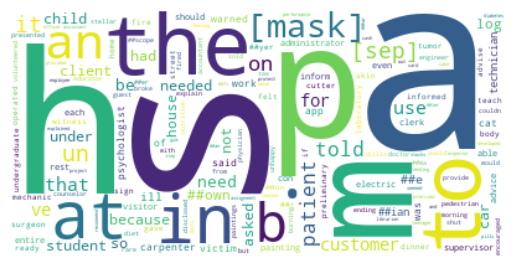

In [42]:
word_cloud = word_cloud.generate_from_frequencies(important_male_word_freq)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

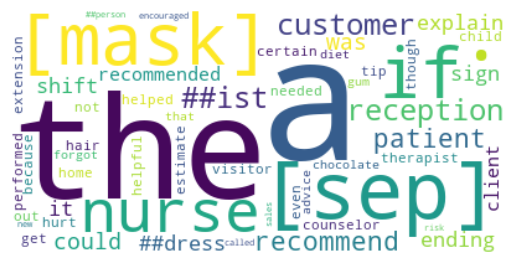

In [43]:
word_cloud = word_cloud.generate_from_frequencies(important_female_word_freq)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### Word Cloud without Frequency (Relative Scaling)

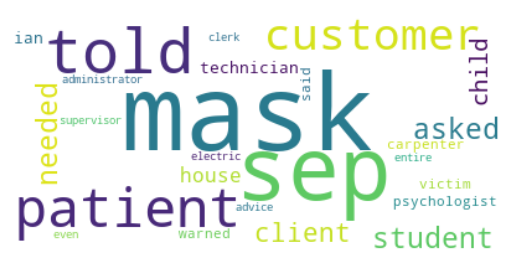

In [44]:
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      relative_scaling=1, 
                      max_words = 25).generate(important_male_text) # Remove max_words to include all words

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

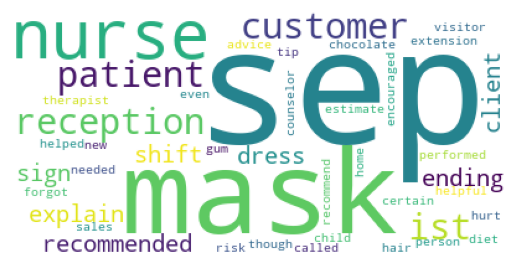

In [45]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(important_female_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##### Word Cloud using TF-IDF

In [46]:
# _important_male_tokens

In [47]:
_important_male_tokens_text, _important_female_tokens_text = [], []

for i, row in enumerate(_important_male_tokens):
    _important_male_tokens_text.append(" ".join(row).lower())

for i, row in enumerate(_important_female_tokens):
    _important_female_tokens_text.append(" ".join(row).lower())

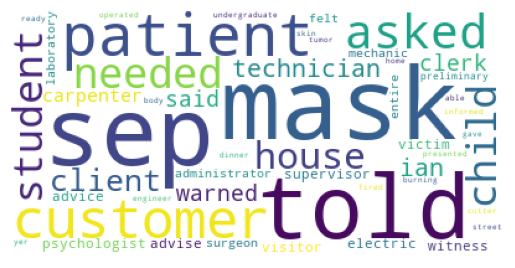

In [48]:
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(_important_male_tokens_text)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
_df_male = pd.DataFrame(lst1, columns=feature_names)

male_tfidf_cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(_df_male.T.sum(axis=1))
plt.imshow(male_tfidf_cloud)
plt.axis("off")
plt.show()

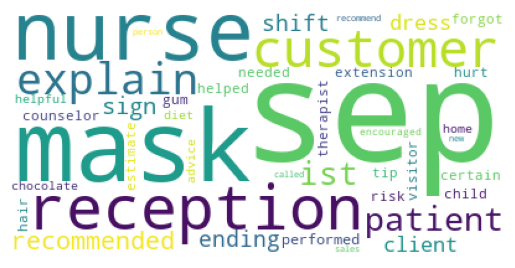

In [49]:
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(_important_female_tokens_text)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
_df_female = pd.DataFrame(lst1, columns=feature_names)

female_tfidf_cloud = WordCloud(background_color="white").generate_from_frequencies(_df_female.T.sum(axis=1))
plt.imshow(female_tfidf_cloud)
plt.axis("off")
plt.show()

#### How important is occupation?

In [51]:
df_gender_quants = pd.read_csv("./dataset/df_generated_gender_quants.csv")
df_gender_quants.drop(columns=["index"], inplace=True)

In [52]:
df_gender_quants.head(15)

,occupation,participant,male_pred,male_prob,male_word_imp,male_tokens,female_pred,female_prob,female_word_imp,female_tokens
0,technician,customer,he,0.651657,"[0.06173572934531598, 0.07724038119584334, 0.1...","['[SEP]', 'that', 'customer', '.', 'technician']",she,0.095750,"[0.06173572934531598, 0.07724038119584334, 0.1...","['[SEP]', 'that', 'customer', '.', 'technician']"
1,mechanic,customer,he,0.760868,"[0.0494035825729952, 0.07990257531111353, 0.18...","['[MASK]', 'pay', 'told', '.', 'customer']",she,0.056780,"[0.0494035825729952, 0.07990257531111353, 0.18...","['[MASK]', 'pay', 'told', '.', 'customer']"
2,supervisor,customer,he,0.667008,"[0.08757796492512444, 0.10723605164769162, 0.1...","['the', 'that', 'told', '.', 'customer']",she,0.078743,"[0.08757796492512444, 0.10723605164769162, 0.1...","['the', 'that', 'told', '.', 'customer']"
3,engineer,customer,he,0.794895,"[0.04714853702209728, 0.06460727437935977, 0.0...","['told', 'engineer', 'that', '.', 'customer']",she,0.037605,"[0.04714853702209728, 0.06460727437935977, 0.0...","['told', 'engineer', 'that', '.', 'customer']"
4,electrician,customer,he,0.767872,"[0.09191394304249864, 0.1146822538759174, 0.18...","['The', '.', 'customer', 'electric', '##ian']",she,0.065376,"[0.09191394304249864, 0.1146822538759174, 0.18...","['The', '.', 'customer', 'electric', '##ian']"
5,supervisor,employee,his,0.520671,"[0.10223976427573817, 0.11011257209765155, 0.1...","['supervisor', 'performance', 'the', '[SEP]', ...",her,0.274540,"[0.10223976427573817, 0.11011257209765155, 0.1...","['supervisor', 'performance', 'the', '[SEP]', ..."
6,technician,employee,his,0.525337,"[0.06367010644683532, 0.08320161418923167, 0.0...","['employee', '.', 'stellar', 'performance', 't...",her,0.323651,"[0.06367010644683532, 0.08320161418923167, 0.0...","['employee', '.', 'stellar', 'performance', 't..."
7,manager,employee,his,0.556856,"[0.06877427244774192, 0.07588598366583836, 0.0...","['employee', 'on', 'the', 'performance', 'stel...",her,0.275916,"[0.06877427244774192, 0.07588598366583836, 0.0...","['employee', 'on', 'the', 'performance', 'stel..."
8,administrator,employee,his,0.498514,"[0.07334640643633371, 0.14874227127082593, 0.1...","['[SEP]', 'gave', 'employee', 'feedback', 'adm...",her,0.291702,"[0.07334640643633371, 0.14874227127082593, 0.1...","['[SEP]', 'gave', 'employee', 'feedback', 'adm..."
9,inspector,employee,his,0.604440,"[0.07035001832028874, 0.07849851354795578, 0.1...","['.', 'the', '[SEP]', 'feedback', 'stellar']",her,0.234908,"[0.07035001832028874, 0.07849851354795578, 0.1...","['.', 'the', '[SEP]', 'feedback', 'stellar']"


In [53]:
occupation_in_wip = []
for i, row in df_gender_quants.iterrows():
    if row["occupation"] in row["male_tokens"]:
        print(row["occupation"])
        occupation_in_wip.append(row["occupation"])
        
len(occupation_in_wip)

technician
engineer
supervisor
technician
administrator
technician
mechanic
worker
educator
teacher
counselor
instructor
librarian
clerk
supervisor
therapist
psychologist
advisor
educator
supervisor
officer
mechanic
technician
manager
supervisor
administrator
secretary
officer
psychologist
counselor
doctor
educator
nurse
clerk
librarian
teacher
educator
administrator
counselor
accountant
administrator
physician
nurse
carpenter
worker
mechanic
psychologist
therapist
counselor
physician
surgeon
carpenter
investigator
bartender
clerk
specialist
technician
practitioner
instructor
counselor
carpenter
mechanic
officer
inspector
supervisor
psychologist
therapist
teacher
librarian
nurse
psychologist
accountant
engineer
practitioner
surgeon
carpenter
surgeon
doctor
nurse
technician
chemist
engineer
technician
carpenter
technician
broker
inspector
psychologist
doctor
chef
programmer
engineer
architect
mechanic
accountant
lawyer
clerk
nurse
surgeon
physician
chemist
investigator
supervisor
clerk


123

In [54]:
# Percentage of Occupation bias in predictions
len(occupation_in_wip)/df_gender_quants.shape[0]*100.2

43.70425531914894

In [55]:
participant_in_wip = []
for i, row in df_gender_quants.iterrows():
    if row["participant"] in row["male_tokens"]:
        print(row["participant"])
        participant_in_wip.append(row["participant"])
        
len(participant_in_wip)

customer
customer
customer
customer
customer
employee
employee
employee
client
client
client
client
client
pedestrian
pedestrian
pedestrian
pedestrian
student
student
student
student
student
customer
customer
patient
patient
patient
customer
teenager
teenager
teenager
undergraduate
undergraduate
customer
customer
customer
visitor
child
child
child
child
patient
patient
child
child
child
child
child
patient
patient
patient
patient
patient
patient
patient
patient
patient
patient
customer
customer
customer
customer
patient
patient
patient
victim
victim
student
student
student
student
witness
witness
witness
witness
witness
resident
resident
patient
patient
patient
owner
owner
owner
passenger
passenger
victim
victim
victim
victim
victim
visitor
child
child
buyer
patient
patient
customer
customer
student
student
student
student
student
client
client
client
client
patient
patient
patient
patient
undergraduate
undergraduate
undergraduate
customer
customer
customer
client
client
customer
custo

142

In [56]:
# Percentage of Occupation bias in predictions
len(participant_in_wip)/df_gender_quants.shape[0]*100.2

50.45531914893617

# Dummy

In [21]:
for i in _top_5:
    print(all_occupations[i])

nurse
doctor
pharmacist
paramedic
receptionist
physician
